In [1]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder


import sys
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path('../data/' + dataset_name + '.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        # print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# train.loc[train[target] == 0, target] = "wealthy"
# train.loc[train[target] == 1, target] = "not_wealthy"

unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

File already exists.


In [3]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
d_val = lgb.Dataset(X_valid, label=y_valid)

In [4]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_val])

In [5]:
# Make predictions on the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8619528619528619


In [6]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[array([[-9.69577295e-01, -2.75987607e-02,  4.02048751e-01,
         -7.80165966e-02, -5.56665135e-01, -1.33985204e+00,
         -7.77742766e-01, -9.31476907e-01, -9.36644757e-02,
         -2.85588608e-01, -5.90983823e+00,  1.35629946e-01,
         -2.98124379e-01, -5.72355457e-02],
        [-2.89383631e-01, -5.74536579e-02,  5.90427525e-01,
         -3.86463253e-01, -2.74953341e-01, -1.42853358e+00,
         -2.21695489e-01, -6.30276724e-01, -3.08283243e-01,
         -3.84069483e-01,  4.96720606e-01,  1.28272851e-01,
         -3.17443777e-01,  1.14804659e-01],
        [-2.63360019e+00,  4.97009604e-02,  2.04336438e+00,
          1.40108136e-01,  8.09969971e-01,  2.40440990e+00,
          1.14242742e+00,  4.86707621e-01,  1.12187428e+00,
          8.77068389e-01,  4.85996647e-01,  8.38260273e-02,
          2.90442167e+00, -1.50278500e-01],
        [-1.11471336e+00, -1.97625608e-01, -1.21226672e+00,
         -8.67666358e-02,  3.29072973e-01, -2.87920137e-01,
         -1.12677623e+00,  3

In [7]:
len(shap_values)
shap_values[0].shape

(3267, 14)

In [8]:
# normalized_shap_values = np.array([vals / np.sum(np.abs(vals)) if np.sum(np.abs(vals)) != 0 else vals for vals in shap_values])
from sklearn.preprocessing import normalize

# Assuming shap_values is your numpy array containing the SHAP values

# Normalize shap_values by row
normalized_shap_values = normalize(shap_values[1], norm='l1', axis=1)
normalized_shap_values
print(np.sum(normalized_shap_values[0]))


0.9093524397469849


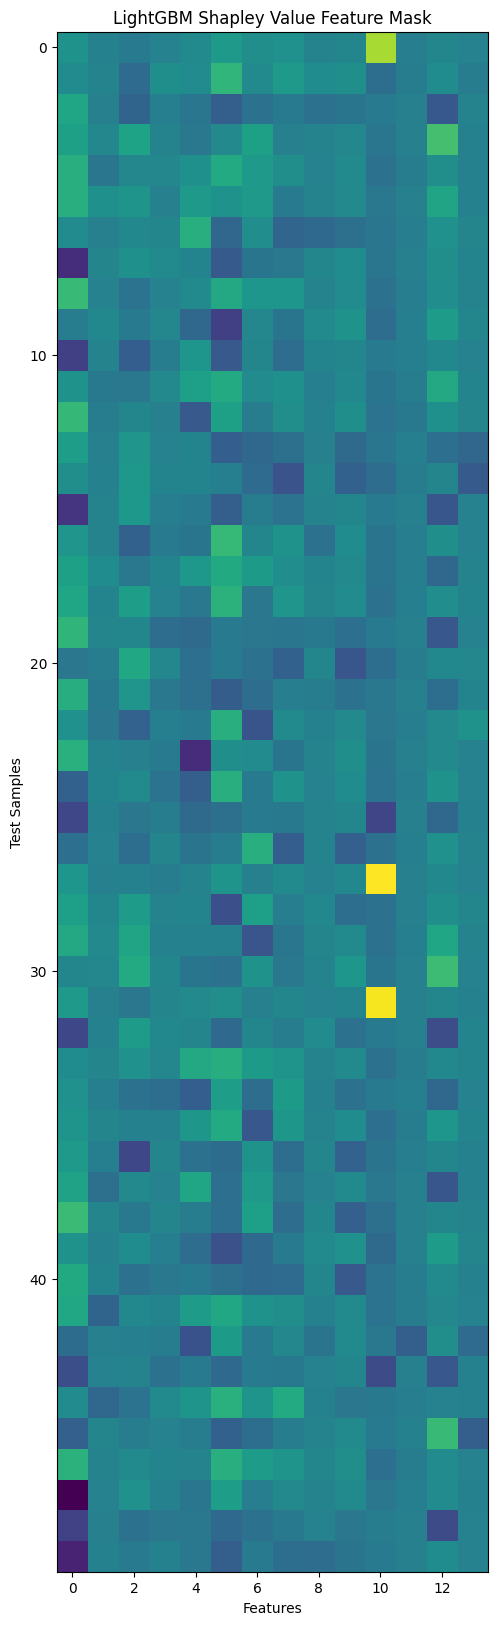

In [9]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.imshow(normalized_shap_values[:50])
axs.set_title(f"LightGBM Shapley Value Feature Mask")
axs.set_ylabel("Test Samples")
axs.set_xlabel("Features")

plt.savefig("lightgbm_optimized_shapley_mask.png")

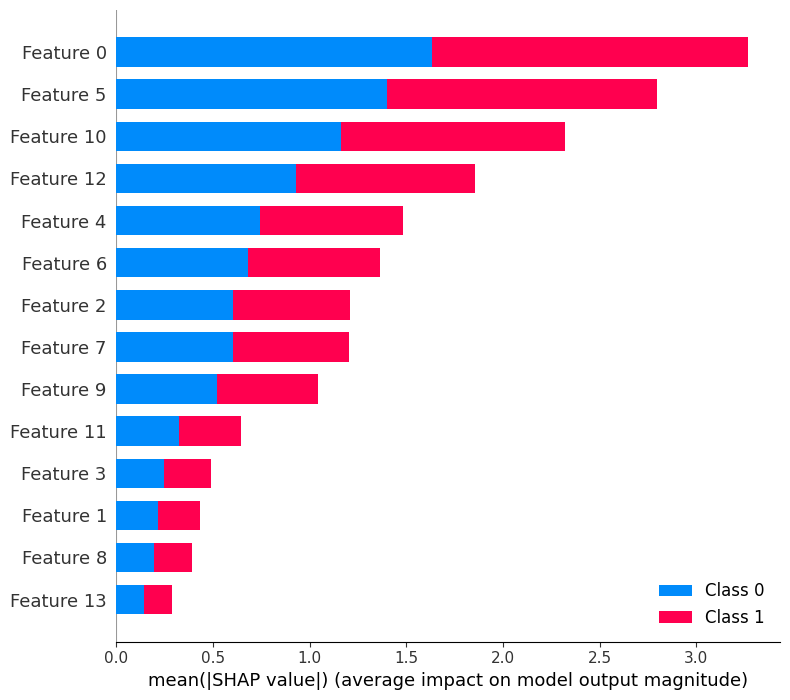

In [10]:
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("lightgbm_census_shap_summary_plot.png") #.png,.pdf will also support here